# Chapter03 분류

In [16]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import pandas as pd

MNIST 데이터셋

In [17]:
# MNIST 데이터셋을 내려받는 코드

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [18]:
X, y = mnist['data'], mnist['target']
print(X.shape)  # 784=28*28, 이미지
print(y.shape)  # 타깃값

(70000, 784)
(70000,)


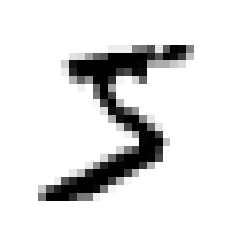

In [19]:
some_digit = X[0]   # 첫 번째 샘플
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [20]:
y[0]   # 첫 번째 샘플의 타깃값

'5'

In [21]:
y = y.astype(np.uint8)  # y를 정수로 변환

In [22]:
# (잘 섞여진 데이터) 훈련세트, 테스트세트로 나누기
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 3.2 이진 분류기 훈련

단순화해서 5인지 아닌지를 구분하는 '5-감지기'를 만들어보자

In [23]:
# 5이면 True, 아니면 False
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [24]:
# 확률적경사하강법 (SGD) 분류기로 훈련
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
sgd_clf.predict([some_digit])   # 훈련한 SGD모델로 첫 번째 샘플 예측

# True (5가 맞음)으로 예측

array([ True])

### 3.3 성능 측정

교차검증으로 정확도 측정

In [26]:
# 교차 검증 구현  (cross_val_score()함수와 거의 같음)
from sklearn.model_selection import StratifiedKFold    # 계층적 샘플링이 적용된 K-폴드
from sklearn.base import clone#  동일한 모수를 사용하여 새로운 적합하지 않은 추정량을 생성함

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

# X_train을 y_train_5 의 클래스별 비율이 유지되도록 폴드를 만듦
for train_index, test_index in skfolds.split(X_train, y_train_5):  # train_index: 훈련세트
    clone_clf = clone(sgd_clf)                                     # test_index:  검증세트
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)  # 훈련세트에서 훈련
    y_pred = clone_clf.predict(X_test_fold)      # 검증세트에서 예측
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [39]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [40]:
# 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기

# 사이킷런의 BaseEsimators를 활용하면 Customized된 Estimator 생성 가능
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)   # 모두 '5가 아니다'라고 예측

In [41]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

더미 분류기를 사용했음에도 불구하고 정확도가 높게 나옴 --> 성능 측정 지표로 정확도는 부적절하다!!

---

- 오차 행렬 :
 
 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것

In [53]:
# 실제 타깃값과 비교할 수 있는 예측값 만들기
from sklearn.model_selection import cross_val_predict

# 각 검증 폴드에서 얻은 예측 반환
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [54]:
# 오차 행렬 만들기
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- 행 : 실제 클래스

- 열 : 예측한 클래스

 첫 번째 : 음성 클래스, 두 번째 : 양성 클래스

정밀도 (precision) = $\frac{TP}{TP + FP}$ : 양성으로 예측한 것중 진짜 양성의 비율

재현율 (recall) = $\frac{TP}{TP + FN}$ : 실제 양성인 것중 제대로 예측한 것의 비율

( $TP$ : 진짜 양성, $TN$ : 진짜 음성, $FP$ : 거짓 양성, $FN$ : 거짓 음성 )

In [55]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))  # 정밀도
print(recall_score(y_train_5, y_train_pred))     # 재현율

0.8370879772350012
0.6511713705958311


- F1 점수 : 정밀도와 재현율의 조화 평균

 $F1 = \frac{2}{\frac{1}{정밀도}+ \frac{1}{재현율}}$

 정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높다.

 하지만 상황에 따라 정밀도와 재현율의 중요도가 다를 수 있다.

In [56]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846